In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(473)

In [ ]:
device=""
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")
device

device(type='cuda')

In [ ]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [ ]:
train_set=torchvision.datasets.MNIST(root=".",train=True,download=True,transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 34066500.64it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43133202.34it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18604032.00it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:

#K=torch.Tensor(next(itt))
#torch.cat((K,next(itt)))

In [ ]:
batch_size=32
train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
#itt=iter(train_set)



In [ ]:
#for i in range(len(train_set)-1):
 # k=next(itt)

def dataex(n):
  itt=iter(train_set)
  DATA=[]
  for i in range(len(train_set)):
    K=next(itt)
    if K[1] in n:
      DATA.append((K[0],K[1]))
  return DATA

class Customdata(torch.utils.data.Dataset):
  def __init__(self,n,transform=None):
    self.dat=dataex(n)
    self.transform=transform
  def __len__(self):
    return len(self.dat)
  def __getitem__(self,index):
    #if self.transform:
    #  img=self.transform(self.dat[index][0])
    return (self.dat[index][0],self.dat[index][1])


In [ ]:
#dat=Customdata([9,0,1,2,3,4,5,6,7,8])
dat=Customdata([7])

In [ ]:

def create(n):
  itt=iter(train_set)
  temp=torch.utils.data.ConcatDataset([next(iter(train_set))])
  for i in range(len(train_set)-1):
    K=next(itt)
    if K[1]==n:
      temp=torch.utils.data.ConcatDataset([temp,K])
      #print(n)

  #while next(iter(train_set)):
   # "Asf"
    #print("K")
    #if n==K[1]:
     # temp=torch.utils.data.ConcatDataset([temp,next(iter(train_set))])
     # print('hi')
  #return temp
  return temp


In [ ]:
#temp=torch.utils.data.DataLoader(None)
#temp=torch.utils.data.ConcatDataset([next(iter(train_loader))])
#temp=create(7)
train_loader2=torch.utils.data.DataLoader(dat,batch_size=batch_size,shuffle=True)

In [ ]:
#K=next(iter(train_loader))
#K
len(train_loader),len(train_loader2)#,len(temp),len(train_set)
#plt.imshow(real_samples[0].reshape(28,28),cmap='gray')

(1875, 196)

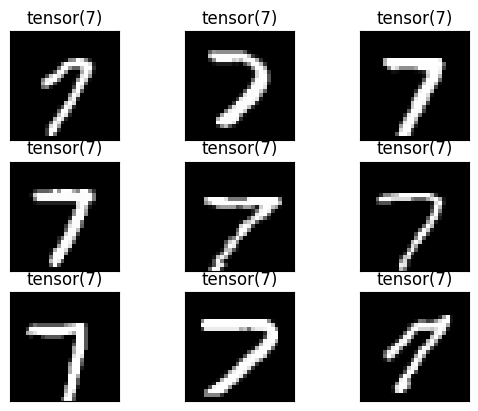

In [ ]:
real_samples,mnist_labels=next(iter(train_loader2))
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(real_samples[i].reshape(28,28),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(mnist_labels[i])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(28*28,1024),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(1024,512),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(512,256),nn.ReLU(),nn.Dropout(0.3),
            nn.Linear(256,1),nn.Sigmoid())
    def forward(self,x):
        x=x.view(x.size(0),28*28)
        output=self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(100,256),nn.ReLU(),
                                 nn.Linear(256,512),nn.ReLU(),
                                 nn.Linear(512,1024),nn.ReLU(),
                                 nn.Linear(1024,28*28),nn.Tanh())
    def forward(self,x):
        output=self.model(x)
        #print('p')
        return output.view(x.size(0),1,28,28)

In [ ]:
discriminator,generator=Discriminator().to(device=device),Generator().to(device=device)

In [ ]:
lr=0.0001
num_epochs=100
loss_function=nn.BCELoss()

optimizer_d=torch.optim.Adam(discriminator.parameters(),lr=lr)
optimizer_g=torch.optim.Adam(generator.parameters(),lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples,mnist_labels) in enumerate(train_loader2):
        #if n==batch_size-2:
         # break
        real_samples=real_samples.to(device=device)
        #print(real_samples.shape)
        real_samples_labels=torch.ones((batch_size,1)).to(device=device)
        latent_space_samples=torch.randn((batch_size,100)).to(device=device)
        generated_samples=generator(latent_space_samples)
        #print(generated_samples.shape)
        generated_samples_labels=torch.zeros((batch_size,1)).to(device=device)
        all_samples=torch.cat((real_samples,generated_samples))
        all_samples_labels=torch.cat((real_samples_labels,generated_samples_labels))

        discriminator.zero_grad()
        output_discriminator=discriminator(all_samples)
        #print(output_discriminator.shape)
        loss_discriminator=loss_function(output_discriminator,all_samples_labels)
        loss_discriminator.backward()
        optimizer_d.step()


        latent_space_samples=torch.randn((batch_size,100)).to(device=device)

        generator.zero_grad()
        generated_samples=generator(latent_space_samples)
        output_discriminator_generated=discriminator(generated_samples)
        loss_generator=loss_function(output_discriminator_generated,real_samples_labels)
        loss_generator.backward()
        optimizer_g.step()

        if n==batch_size-2:
            print(f"epoch : {epoch} Loss D: {loss_discriminator}")
            print(f"epoch : {epoch} Loss G: {loss_generator}")
            break

epoch : 0 Loss D: 0.5157139301300049
epoch : 0 Loss G: 0.5180379748344421
epoch : 1 Loss D: 0.6478623747825623
epoch : 1 Loss G: 0.8086296319961548
epoch : 2 Loss D: 0.1976015269756317
epoch : 2 Loss G: 2.0110812187194824
epoch : 3 Loss D: 0.18628856539726257
epoch : 3 Loss G: 1.8285956382751465
epoch : 4 Loss D: 0.16610440611839294
epoch : 4 Loss G: 1.75335693359375
epoch : 5 Loss D: 0.17349597811698914
epoch : 5 Loss G: 1.4337286949157715
epoch : 6 Loss D: 0.09379225969314575
epoch : 6 Loss G: 1.9077205657958984
epoch : 7 Loss D: 0.10156096518039703
epoch : 7 Loss G: 2.0638835430145264
epoch : 8 Loss D: 0.06296917796134949
epoch : 8 Loss G: 2.905857563018799
epoch : 9 Loss D: 0.23465333878993988
epoch : 9 Loss G: 2.8500566482543945
epoch : 10 Loss D: 0.1904074251651764
epoch : 10 Loss G: 5.969527244567871
epoch : 11 Loss D: 0.01704031229019165
epoch : 11 Loss G: 7.055681228637695
epoch : 12 Loss D: 0.18988990783691406
epoch : 12 Loss G: 5.363645553588867
epoch : 13 Loss D: 0.19962938

In [ ]:
latent_space_samples=torch.randn(batch_size,100).to(device=device)
generated_s=generator(latent_space_samples).cpu().detach()


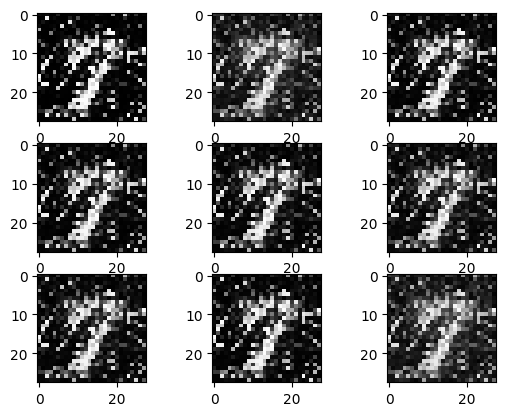

In [ ]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(generated_s[i].reshape(28,28),cmap='gray')
